# Feature Engineering for K-Means Behavioral Clustering

**Objective**: Build a customer-level feature matrix with 9 behavioral features for K-means clustering.

## Finalized Feature Set

| Feature | Definition | Transform |
|---------|-----------|----------|
| `frequency` | Order count per customer | log1p |
| `monetary_total` | Lifetime spend (BRL) | log1p |
| `monetary_avg_item` | Avg item price (total_spend / total_items) | log1p |
| `avg_items_per_order` | Basket size (total_items / total_orders) | log1p |
| `avg_installments` | Mean installments per order | none |
| `pct_credit_card` | % of orders paid by credit card | none |
| `category_diversity` | Distinct categories (lifetime) | none |
| `is_positive_reviewer` | Binary: avg score ≥ 4 | none |
| `is_weekend_shopper` | Binary: any purchase on Sat/Sun | none |

**Key design decisions** (see `FEATURE_ENG_CONTEXT.md`):
- Dropped: `tenure_days` (97% zero-inflated), `pct_late_delivery` (not customer behavior)
- Only include `order_status == 'delivered'` orders
- Review NaN filled with 0 (conservative: not positive)

## 1. Environment Setup

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Paths
DATA_DIR = Path('../data/raw')
OUTPUT_DIR = Path('../data/processed')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Data directory: {DATA_DIR.resolve()}")
print(f"Output directory: {OUTPUT_DIR.resolve()}")

Data directory: /Users/emilyhk/practice/blok-persona-clustering/data/raw
Output directory: /Users/emilyhk/practice/blok-persona-clustering/data/processed


## 2. Data Loading

In [62]:
# Load all required datasets
customers = pd.read_csv(DATA_DIR / 'olist_customers_dataset.csv')

orders = pd.read_csv(
    DATA_DIR / 'olist_orders_dataset.csv',
    parse_dates=['order_purchase_timestamp', 'order_approved_at',
                 'order_delivered_carrier_date', 'order_delivered_customer_date',
                 'order_estimated_delivery_date']
)

order_items = pd.read_csv(
    DATA_DIR / 'olist_order_items_dataset.csv',
    parse_dates=['shipping_limit_date']
)

payments = pd.read_csv(DATA_DIR / 'olist_order_payments_dataset.csv')

reviews = pd.read_csv(
    DATA_DIR / 'olist_order_reviews_dataset.csv',
    parse_dates=['review_creation_date', 'review_answer_timestamp']
)

products = pd.read_csv(DATA_DIR / 'olist_products_dataset.csv')

category_translation = pd.read_csv(DATA_DIR / 'product_category_name_translation.csv')

print('All datasets loaded successfully.')
print(f"\nDataset shapes:")
print(f"  customers: {customers.shape}")
print(f"  orders: {orders.shape}")
print(f"  order_items: {order_items.shape}")
print(f"  payments: {payments.shape}")
print(f"  reviews: {reviews.shape}")
print(f"  products: {products.shape}")

All datasets loaded successfully.

Dataset shapes:
  customers: (99441, 5)
  orders: (99441, 8)
  order_items: (112650, 7)
  payments: (103886, 5)
  reviews: (99224, 7)
  products: (32951, 9)


In [63]:
# Merge products with English category names
products_with_cat = products.merge(
    category_translation,
    on='product_category_name',
    how='left'
)

print(f"Products with category translation: {len(products_with_cat):,}")
print(f"Missing category translations: {products_with_cat['product_category_name_english'].isna().sum():,}")

Products with category translation: 32,951
Missing category translations: 623


In [64]:
# Filter to delivered orders only (critical for behavioral analysis)
delivered_orders = orders[orders['order_status'] == 'delivered'].copy()
print(f"Total orders: {len(orders):,}")
print(f"Delivered orders: {len(delivered_orders):,} ({len(delivered_orders)/len(orders)*100:.1f}%)")

Total orders: 99,441
Delivered orders: 96,478 (97.0%)


## 3. Build Master Table

Create a single master table joining orders, customers, items, and products to avoid repeated joins.

In [65]:
# Build master order-customer-item table
master_df = (
    delivered_orders
    .merge(customers, on='customer_id')
    .merge(order_items, on='order_id')
    .merge(
        products_with_cat[['product_id', 'product_category_name_english']],
        on='product_id',
        how='left'
    )
)

print(f"Master table shape: {master_df.shape}")
print(f"Unique customers: {master_df['customer_unique_id'].nunique():,}")
print(f"Unique orders: {master_df['order_id'].nunique():,}")

Master table shape: (110197, 19)
Unique customers: 93,358
Unique orders: 96,478


## 4. Feature Calculation

Calculate each of the 9 features at the customer level.

### 4.1 Frequency (Order count per customer)

In [66]:
# Order count per unique customer
frequency = (
    delivered_orders
    .merge(customers, on='customer_id')
    .groupby('customer_unique_id')['order_id']
    .nunique()
    .rename('frequency')
)

print(f"Frequency calculated for {len(frequency):,} customers")
print(f"\nDistribution:")
print(frequency.describe())

Frequency calculated for 93,358 customers

Distribution:
count   93358.0000
mean        1.0334
std         0.2091
min         1.0000
25%         1.0000
50%         1.0000
75%         1.0000
max        15.0000
Name: frequency, dtype: float64


### 4.2 Monetary Total (Lifetime spend)

In [67]:
# Total spend per customer (sum of item prices)
monetary_total = (
    master_df
    .groupby('customer_unique_id')['price']
    .sum()
    .rename('monetary_total')
)

print(f"Monetary total calculated for {len(monetary_total):,} customers")
print(f"\nDistribution (BRL):")
print(monetary_total.describe())

Monetary total calculated for 93,358 customers

Distribution (BRL):
count   93358.0000
mean      141.6215
std       215.6940
min         0.8500
25%        47.6500
50%        89.7300
75%       154.7375
max     13440.0000
Name: monetary_total, dtype: float64


### 4.3 Monetary Avg Item (Average item price)

In [68]:
# Average item price: total_spend / total_items
item_agg = (
    master_df
    .groupby('customer_unique_id')
    .agg(
        total_spend=('price', 'sum'),
        total_items=('order_item_id', 'count')
    )
)

monetary_avg_item = (item_agg['total_spend'] / item_agg['total_items']).rename('monetary_avg_item')

print(f"Monetary avg item calculated for {len(monetary_avg_item):,} customers")
print(f"\nDistribution (BRL per item):")
print(monetary_avg_item.describe())

Monetary avg item calculated for 93,358 customers

Distribution (BRL per item):
count   93358.0000
mean      125.8295
std       190.5335
min         0.8500
25%        42.9000
50%        79.0000
75%       139.9000
max      6735.0000
Name: monetary_avg_item, dtype: float64


### 4.4 Avg Items Per Order (Basket size)

In [69]:
# Basket size: total_items / total_orders
# First count items per order, then average per customer
items_per_order = (
    master_df
    .groupby(['customer_unique_id', 'order_id'])
    .size()
    .rename('items_in_order')
)

avg_items_per_order = (
    items_per_order
    .groupby('customer_unique_id')
    .mean()
    .rename('avg_items_per_order')
)

print(f"Avg items per order calculated for {len(avg_items_per_order):,} customers")
print(f"\nDistribution:")
print(avg_items_per_order.describe())

Avg items per order calculated for 93,358 customers

Distribution:
count   93358.0000
mean        1.1395
std         0.5271
min         1.0000
25%         1.0000
50%         1.0000
75%         1.0000
max        21.0000
Name: avg_items_per_order, dtype: float64


### 4.5 Avg Installments

In [70]:
# Join orders-customers-payments for delivered orders
payment_df = (
    delivered_orders
    .merge(customers, on='customer_id')
    .merge(payments, on='order_id')
)

# Average installments: mean within order (for multi-payment orders), then mean across customer
avg_installments = (
    payment_df
    .groupby(['customer_unique_id', 'order_id'])['payment_installments']
    .mean()  # Within order
    .groupby('customer_unique_id')
    .mean()  # Across orders
    .rename('avg_installments')
)

print(f"Avg installments calculated for {len(avg_installments):,} customers")
print(f"\nDistribution:")
print(avg_installments.describe())

Avg installments calculated for 93,357 customers

Distribution:
count   93357.0000
mean        2.8998
std         2.6759
min         0.0000
25%         1.0000
50%         2.0000
75%         4.0000
max        24.0000
Name: avg_installments, dtype: float64


### 4.6 Pct Credit Card

In [71]:
# Flag each order as credit card (if ANY payment in that order is CC)
order_has_cc = (
    payment_df
    .groupby(['customer_unique_id', 'order_id'])['payment_type']
    .apply(lambda x: 'credit_card' in x.values)
)

# Percentage of orders with credit card per customer
pct_credit_card = (
    order_has_cc
    .groupby('customer_unique_id')
    .mean()
    .rename('pct_credit_card')
)

print(f"Pct credit card calculated for {len(pct_credit_card):,} customers")
print(f"\nDistribution:")
print(pct_credit_card.describe())

Pct credit card calculated for 93,357 customers

Distribution:
count   93357.0000
mean        0.7701
std         0.4199
min         0.0000
25%         1.0000
50%         1.0000
75%         1.0000
max         1.0000
Name: pct_credit_card, dtype: float64


### 4.7 Category Diversity

In [72]:
# Count of distinct categories per customer (lifetime)
category_diversity = (
    master_df
    .groupby('customer_unique_id')['product_category_name_english']
    .nunique()
    .rename('category_diversity')
)

print(f"Category diversity calculated for {len(category_diversity):,} customers")
print(f"\nDistribution:")
print(category_diversity.describe())

Category diversity calculated for 93,358 customers

Distribution:
count   93358.0000
mean        1.0110
std         0.2046
min         0.0000
25%         1.0000
50%         1.0000
75%         1.0000
max         5.0000
Name: category_diversity, dtype: float64


### 4.8 Is Positive Reviewer

In [73]:
# Join orders-customers-reviews for delivered orders
review_df = (
    delivered_orders
    .merge(customers, on='customer_id')
    .merge(reviews[['order_id', 'review_score']], on='order_id', how='left')
)

# Average review score per customer
avg_review = (
    review_df
    .groupby('customer_unique_id')['review_score']
    .mean()
)

# Binary: is positive reviewer (avg score >= 4)
# Fill NaN with 0 (conservative: not positive)
is_positive_reviewer = (
    (avg_review >= 4)
    .astype(int)
    .fillna(0)
    .rename('is_positive_reviewer')
)

print(f"Is positive reviewer calculated for {len(is_positive_reviewer):,} customers")
print(f"\nDistribution:")
print(is_positive_reviewer.value_counts())
print(f"\nNaN in avg_review (filled with 0): {avg_review.isna().sum():,}")

Is positive reviewer calculated for 93,358 customers

Distribution:
is_positive_reviewer
1    73013
0    20345
Name: count, dtype: int64

NaN in avg_review (filled with 0): 603


### 4.9 Is Weekend Shopper

In [74]:
# Extract day of week from order purchase timestamp
# Saturday = 5, Sunday = 6 in pandas dayofweek
weekend_df = (
    delivered_orders
    .merge(customers, on='customer_id')
    .copy()
)
weekend_df['day_of_week'] = weekend_df['order_purchase_timestamp'].dt.dayofweek

# Binary: any purchase on Saturday (5) or Sunday (6)
is_weekend_shopper = (
    weekend_df
    .groupby('customer_unique_id')['day_of_week']
    .apply(lambda x: ((x == 5) | (x == 6)).any())
    .astype(int)
    .rename('is_weekend_shopper')
)

print(f"Is weekend shopper calculated for {len(is_weekend_shopper):,} customers")
print(f"\nDistribution:")
print(is_weekend_shopper.value_counts())

Is weekend shopper calculated for 93,358 customers

Distribution:
is_weekend_shopper
0    71563
1    21795
Name: count, dtype: int64


## 5. Feature Matrix Assembly

In [75]:
# Combine all features into a single DataFrame
feature_matrix = pd.concat([
    frequency,
    monetary_total,
    monetary_avg_item,
    avg_items_per_order,
    avg_installments,
    pct_credit_card,
    category_diversity,
    is_positive_reviewer,
    is_weekend_shopper
], axis=1)

# Drop any customers with missing values (1 customer has no payment data)
n_before = len(feature_matrix)
feature_matrix = feature_matrix.dropna()
n_dropped = n_before - len(feature_matrix)
print(f"Dropped {n_dropped} customer(s) with missing values")

print(f"Feature matrix shape: {feature_matrix.shape}")
print(f"\nColumn dtypes:")
print(feature_matrix.dtypes)

Dropped 1 customer(s) with missing values
Feature matrix shape: (93357, 9)

Column dtypes:
frequency                 int64
monetary_total          float64
monetary_avg_item       float64
avg_items_per_order     float64
avg_installments        float64
pct_credit_card         float64
category_diversity        int64
is_positive_reviewer      int64
is_weekend_shopper        int64
dtype: object


In [76]:
# Check for missing values
missing_summary = pd.DataFrame({
    'missing_count': feature_matrix.isnull().sum(),
    'missing_pct': feature_matrix.isnull().mean() * 100
})
print("Missing value summary:")
print(missing_summary)

Missing value summary:
                      missing_count  missing_pct
frequency                         0       0.0000
monetary_total                    0       0.0000
monetary_avg_item                 0       0.0000
avg_items_per_order               0       0.0000
avg_installments                  0       0.0000
pct_credit_card                   0       0.0000
category_diversity                0       0.0000
is_positive_reviewer              0       0.0000
is_weekend_shopper                0       0.0000


In [77]:
# Display sample of feature matrix
print("Sample rows:")
feature_matrix.head(10)

Sample rows:


,frequency,monetary_total,monetary_avg_item,avg_items_per_order,avg_installments,pct_credit_card,category_diversity,is_positive_reviewer,is_weekend_shopper
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,129.9000,129.9000,1.0000,8.0000,1.0000,1,1,0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.9000,18.9000,1.0000,1.0000,1.0000,1,1,0
0000f46a3911fa3c0805444483337064,1,69.0000,69.0000,1.0000,8.0000,1.0000,1,0,0
0000f6ccb0745a6a4b88665a16c9f078,1,25.9900,25.9900,1.0000,4.0000,1.0000,1,1,0
0004aac84e0df4da2b147fca70cf8255,1,180.0000,180.0000,1.0000,6.0000,1.0000,1,1,0
0004bd2a26a76fe21f786e4fbd80607f,1,154.0000,154.0000,1.0000,8.0000,1.0000,1,1,0
00050ab1314c0e55a6ca13cf7181fecf,1,27.9900,27.9900,1.0000,1.0000,0.0000,1,1,0
00053a61a98854899e70ed204dd4bafe,1,382.0000,191.0000,2.0000,3.0000,1.0000,1,0,0
0005e1862207bf6ccc02e4228effd9a0,1,135.0000,135.0000,1.0000,3.0000,1.0000,1,1,1


## 6. Feature Transformations

Apply log1p transform to skewed features (frequency, monetary_total, monetary_avg_item, avg_items_per_order).

In [78]:
# Apply log1p transformation to skewed features
log_features = ['frequency', 'monetary_total', 'monetary_avg_item', 'avg_items_per_order']

for col in log_features:
    feature_matrix[f'{col}_log'] = np.log1p(feature_matrix[col])
    print(f"Created {col}_log")

print(f"\nFeature matrix shape after transforms: {feature_matrix.shape}")

Created frequency_log
Created monetary_total_log
Created monetary_avg_item_log
Created avg_items_per_order_log

Feature matrix shape after transforms: (93357, 13)


In [79]:
# Define clustering feature set (9 features)
clustering_features = [
    'frequency_log',
    'monetary_total_log',
    'monetary_avg_item_log',
    'avg_items_per_order_log',
    'avg_installments',
    'pct_credit_card',
    'category_diversity',
    'is_positive_reviewer',
    'is_weekend_shopper'
]

# Define raw feature set
raw_features = [
    'frequency',
    'monetary_total',
    'monetary_avg_item',
    'avg_items_per_order',
    'avg_installments',
    'pct_credit_card',
    'category_diversity',
    'is_positive_reviewer',
    'is_weekend_shopper'
]

print(f"Clustering features: {len(clustering_features)}")
print(f"Raw features: {len(raw_features)}")

Clustering features: 9
Raw features: 9


## 7. Data Quality Validation

### 7.1 Summary Statistics

In [80]:
# Summary statistics for clustering features
print("Clustering features - Summary statistics:")
feature_matrix[clustering_features].describe().T

Clustering features - Summary statistics:


,count,mean,std,min,25%,50%,75%,max
frequency_log,93357.0000,0.7062,0.0767,0.6931,0.6931,0.6931,0.6931,2.7726
monetary_total_log,93357.0000,4.4858,0.9235,0.6152,3.8847,4.5076,5.0483,9.5061
monetary_avg_item_log,93357.0000,4.3829,0.9013,0.6152,3.7819,4.3820,4.9481,8.8152
avg_items_per_order_log,93357.0000,0.7433,0.1647,0.6931,0.6931,0.6931,0.6931,3.0910
avg_installments,93357.0000,2.8998,2.6759,0.0000,1.0000,2.0000,4.0000,24.0000
pct_credit_card,93357.0000,0.7701,0.4199,0.0000,1.0000,1.0000,1.0000,1.0000
category_diversity,93357.0000,1.0110,0.2046,0.0000,1.0000,1.0000,1.0000,5.0000
is_positive_reviewer,93357.0000,0.7821,0.4128,0.0000,1.0000,1.0000,1.0000,1.0000
is_weekend_shopper,93357.0000,0.2335,0.4230,0.0000,0.0000,0.0000,0.0000,1.0000


In [81]:
# Summary statistics for raw features
print("Raw features - Summary statistics:")
feature_matrix[raw_features].describe().T

Raw features - Summary statistics:


,count,mean,std,min,25%,50%,75%,max
frequency,93357.0000,1.0334,0.2091,1.0000,1.0000,1.0000,1.0000,15.0000
monetary_total,93357.0000,141.6216,215.6952,0.8500,47.6500,89.7000,154.7500,13440.0000
monetary_avg_item,93357.0000,125.8304,190.5343,0.8500,42.9000,79.0000,139.9000,6735.0000
avg_items_per_order,93357.0000,1.1395,0.5270,1.0000,1.0000,1.0000,1.0000,21.0000
avg_installments,93357.0000,2.8998,2.6759,0.0000,1.0000,2.0000,4.0000,24.0000
pct_credit_card,93357.0000,0.7701,0.4199,0.0000,1.0000,1.0000,1.0000,1.0000
category_diversity,93357.0000,1.0110,0.2046,0.0000,1.0000,1.0000,1.0000,5.0000
is_positive_reviewer,93357.0000,0.7821,0.4128,0.0000,1.0000,1.0000,1.0000,1.0000
is_weekend_shopper,93357.0000,0.2335,0.4230,0.0000,0.0000,0.0000,0.0000,1.0000


### 7.2 Distribution Visualizations - Before/After Log Transform

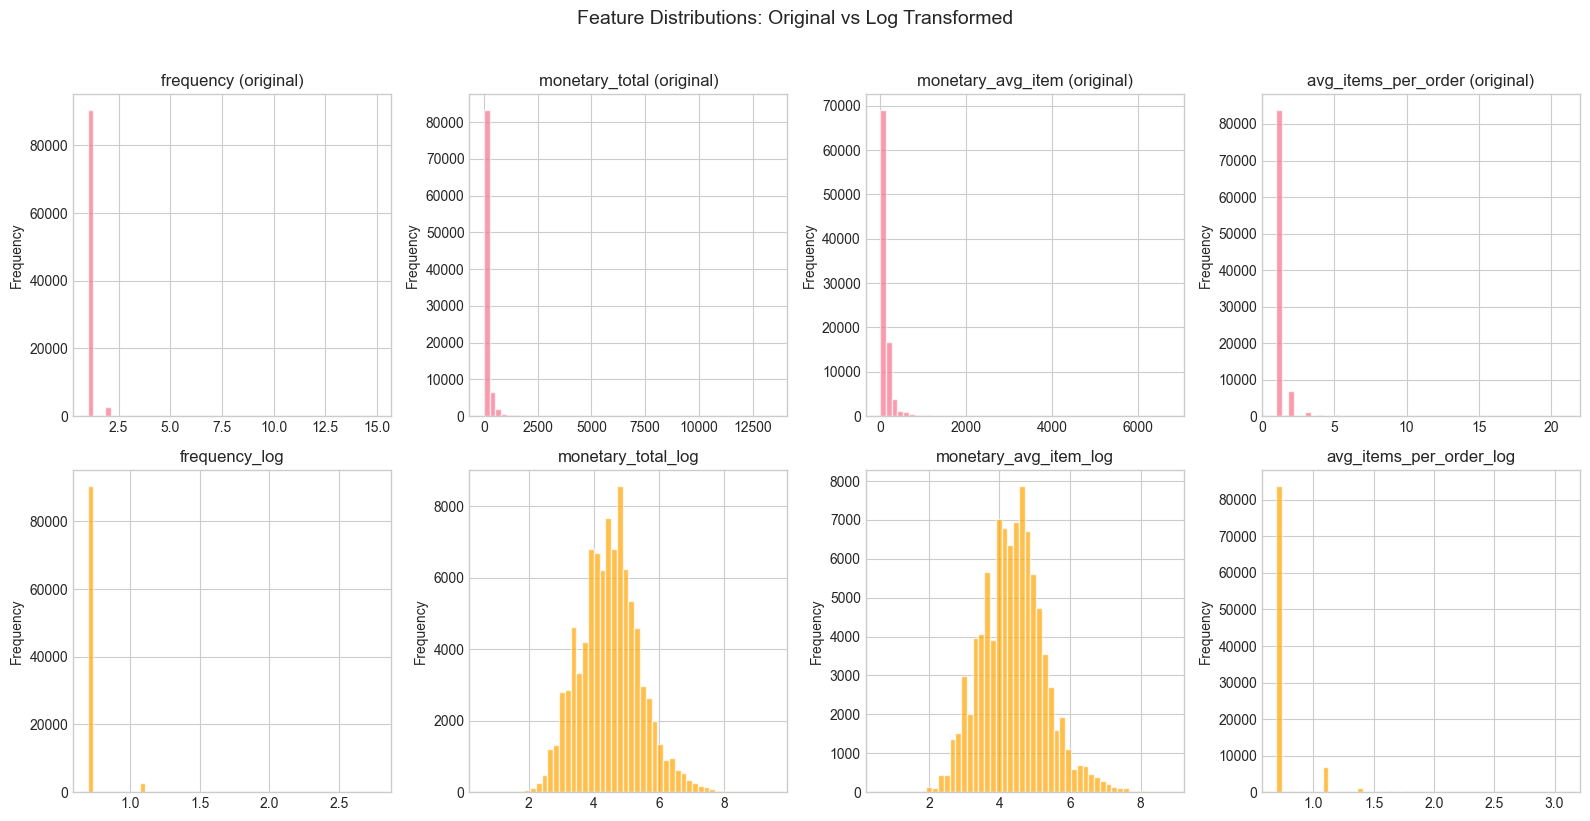

In [82]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Row 1: Original distributions
for i, col in enumerate(log_features):
    feature_matrix[col].hist(bins=50, ax=axes[0, i], edgecolor='white', alpha=0.7)
    axes[0, i].set_title(f'{col} (original)')
    axes[0, i].set_ylabel('Frequency')

# Row 2: Log-transformed distributions
for i, col in enumerate(log_features):
    feature_matrix[f'{col}_log'].hist(bins=50, ax=axes[1, i], edgecolor='white', alpha=0.7, color='orange')
    axes[1, i].set_title(f'{col}_log')
    axes[1, i].set_ylabel('Frequency')

plt.suptitle('Feature Distributions: Original vs Log Transformed', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 7.3 Other Feature Distributions

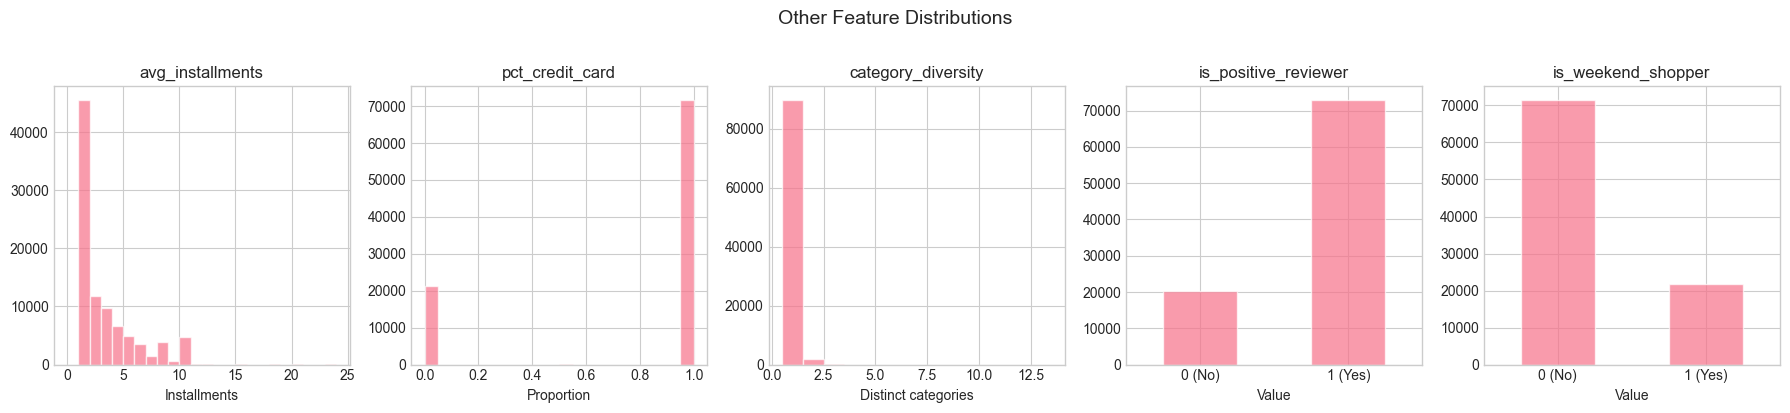

In [83]:
fig, axes = plt.subplots(1, 5, figsize=(18, 4))

# Continuous features
feature_matrix['avg_installments'].hist(bins=24, ax=axes[0], edgecolor='white', alpha=0.7)
axes[0].set_title('avg_installments')
axes[0].set_xlabel('Installments')

feature_matrix['pct_credit_card'].hist(bins=20, ax=axes[1], edgecolor='white', alpha=0.7)
axes[1].set_title('pct_credit_card')
axes[1].set_xlabel('Proportion')

feature_matrix['category_diversity'].hist(bins=range(1, 15), ax=axes[2], edgecolor='white', alpha=0.7, align='left')
axes[2].set_title('category_diversity')
axes[2].set_xlabel('Distinct categories')

# Binary features
feature_matrix['is_positive_reviewer'].value_counts().sort_index().plot(kind='bar', ax=axes[3], edgecolor='white', alpha=0.7)
axes[3].set_title('is_positive_reviewer')
axes[3].set_xlabel('Value')
axes[3].set_xticklabels(['0 (No)', '1 (Yes)'], rotation=0)

feature_matrix['is_weekend_shopper'].value_counts().sort_index().plot(kind='bar', ax=axes[4], edgecolor='white', alpha=0.7)
axes[4].set_title('is_weekend_shopper')
axes[4].set_xlabel('Value')
axes[4].set_xticklabels(['0 (No)', '1 (Yes)'], rotation=0)

plt.suptitle('Other Feature Distributions', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 7.4 Outlier Detection (IQR Method)

In [84]:
def detect_outliers_iqr(df, columns, threshold=1.5):
    """Detect outliers using IQR method."""
    results = []
    for col in columns:
        if col not in df.columns:
            continue
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - threshold * IQR
        upper = Q3 + threshold * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        results.append({
            'column': col,
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'lower_bound': lower,
            'upper_bound': upper,
            'outlier_count': len(outliers),
            'outlier_pct': len(outliers) / len(df) * 100
        })
    return pd.DataFrame(results)

# Check clustering features for outliers
print("Outlier Analysis (Clustering Features):")
outliers = detect_outliers_iqr(feature_matrix, clustering_features)
outliers

Outlier Analysis (Clustering Features):


,column,Q1,Q3,IQR,lower_bound,upper_bound,outlier_count,outlier_pct
0,frequency_log,0.6931,0.6931,0.0000,0.6931,0.6931,2801,3.0003
1,monetary_total_log,3.8847,5.0483,1.1636,2.1393,6.7937,1412,1.5125
2,monetary_avg_item_log,3.7819,4.9481,1.1661,2.0327,6.6973,1360,1.4568
3,avg_items_per_order_log,0.6931,0.6931,0.0000,0.6931,0.6931,9485,10.1599
4,avg_installments,1.0000,4.0000,3.0000,-3.5000,8.5000,5592,5.9899
5,pct_credit_card,1.0000,1.0000,0.0000,1.0000,1.0000,21596,23.1327
6,category_diversity,1.0000,1.0000,0.0000,1.0000,1.0000,3440,3.6848
7,is_positive_reviewer,1.0000,1.0000,0.0000,1.0000,1.0000,20344,21.7916
8,is_weekend_shopper,0.0000,0.0000,0.0000,0.0000,0.0000,21795,23.3459


### 7.5 Validation Checks

In [85]:
# Validation checklist
print("VALIDATION CHECKLIST")
print("="*60)

# 1. All 9 features present
all_present = all(col in feature_matrix.columns for col in clustering_features)
print(f"[{'x' if all_present else ' '}] All 9 clustering features present")

# 2. No missing values in clustering columns
no_missing = feature_matrix[clustering_features].isnull().sum().sum() == 0
print(f"[{'x' if no_missing else ' '}] No missing values in clustering features")

# 3. Customer count
n_customers = len(feature_matrix)
print(f"[{'x' if n_customers > 90000 else '?'}] Customer count: {n_customers:,}")

# 4. Binary features are truly binary
binary_check = (
    set(feature_matrix['is_positive_reviewer'].unique()).issubset({0, 1}) and
    set(feature_matrix['is_weekend_shopper'].unique()).issubset({0, 1})
)
print(f"[{'x' if binary_check else ' '}] Binary features are truly binary (0/1)")

# 5. Percentage features in [0, 1] range
pct_check = (
    feature_matrix['pct_credit_card'].min() >= 0 and
    feature_matrix['pct_credit_card'].max() <= 1
)
print(f"[{'x' if pct_check else ' '}] Percentage features in [0, 1] range")

# 6. Index is customer_unique_id
idx_check = feature_matrix.index.name == 'customer_unique_id'
print(f"[{'x' if idx_check else ' '}] Index is customer_unique_id")

print("\n" + "="*60)

VALIDATION CHECKLIST
[x] All 9 clustering features present
[x] No missing values in clustering features
[x] Customer count: 93,357
[x] Binary features are truly binary (0/1)
[x] Percentage features in [0, 1] range
[x] Index is customer_unique_id



### 7.6 Manual Validation (Sample Customers)

In [86]:
# Select a few customers with repeat purchases for manual validation
repeat_customers = frequency[frequency > 1].index[:3].tolist()

for test_customer in repeat_customers:
    print(f"\n{'='*60}")
    print(f"CUSTOMER: {test_customer}")
    print(f"{'='*60}")
    
    # Get orders for this customer
    cust_orders = (
        delivered_orders
        .merge(customers[customers['customer_unique_id'] == test_customer], on='customer_id')
    )
    print(f"\nOrders: {len(cust_orders)}")
    
    # Get items for this customer
    cust_items = master_df[master_df['customer_unique_id'] == test_customer]
    print(f"Items: {len(cust_items)}")
    print(f"Total spend: {cust_items['price'].sum():.2f} BRL")
    print(f"Avg item price: {cust_items['price'].sum() / len(cust_items):.2f} BRL")
    
    # Get payments
    cust_payments = payment_df[payment_df['customer_unique_id'] == test_customer]
    print(f"Credit card orders: {cust_payments.groupby('order_id')['payment_type'].apply(lambda x: 'credit_card' in x.values).sum()} / {cust_payments['order_id'].nunique()}")
    
    # Get categories
    print(f"Distinct categories: {cust_items['product_category_name_english'].nunique()}")
    
    # Get reviews
    cust_reviews = review_df[review_df['customer_unique_id'] == test_customer]
    print(f"Avg review score: {cust_reviews['review_score'].mean():.2f}")
    
    # Weekend purchases
    cust_weekend = weekend_df[weekend_df['customer_unique_id'] == test_customer]
    has_weekend = ((cust_weekend['day_of_week'] == 5) | (cust_weekend['day_of_week'] == 6)).any()
    print(f"Weekend shopper: {has_weekend}")
    
    # Compare with feature matrix
    print(f"\nFeature matrix values:")
    print(feature_matrix.loc[test_customer][raw_features])


CUSTOMER: 004288347e5e88a27ded2bb23747066c

Orders: 2
Items: 2
Total spend: 317.89 BRL
Avg item price: 158.94 BRL
Credit card orders: 2 / 2
Distinct categories: 2
Avg review score: 5.00
Weekend shopper: True

Feature matrix values:
frequency                2.0000
monetary_total         317.8900
monetary_avg_item      158.9450
avg_items_per_order      1.0000
avg_installments         2.0000
pct_credit_card          1.0000
category_diversity       2.0000
is_positive_reviewer     1.0000
is_weekend_shopper       1.0000
Name: 004288347e5e88a27ded2bb23747066c, dtype: float64

CUSTOMER: 00a39521eb40f7012db50455bf083460

Orders: 2
Items: 2
Total spend: 81.45 BRL
Avg item price: 40.73 BRL
Credit card orders: 2 / 2
Distinct categories: 2
Avg review score: 4.00
Weekend shopper: True

Feature matrix values:
frequency               2.0000
monetary_total         81.4500
monetary_avg_item      40.7250
avg_items_per_order     1.0000
avg_installments        1.0000
pct_credit_card         1.0000
categor

## 8. Feature Correlation Matrix

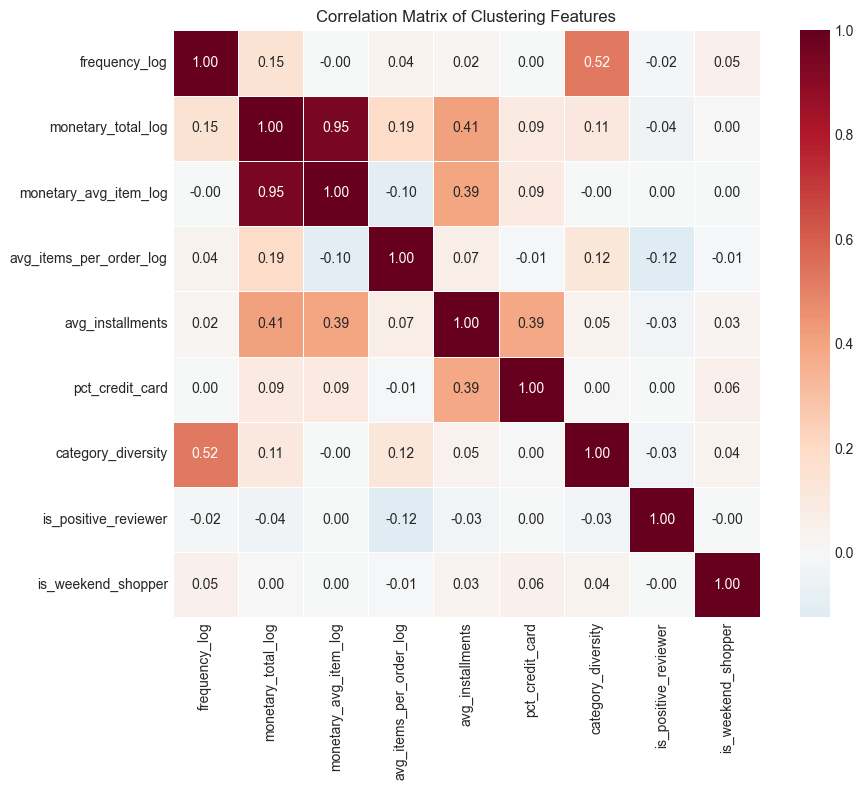

In [87]:
# Correlation matrix for clustering features
corr_matrix = feature_matrix[clustering_features].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.2f',
            square=True, linewidths=0.5, ax=ax)
ax.set_title('Correlation Matrix of Clustering Features')
plt.tight_layout()
plt.show()

## 9. Export Feature Matrices

In [88]:
# 1. Save raw features
feature_matrix[raw_features].to_csv(OUTPUT_DIR / 'customer_features_raw.csv')
print(f"Saved: {OUTPUT_DIR / 'customer_features_raw.csv'}")

# 2. Save transformed features (clustering-ready)
feature_matrix[clustering_features].to_csv(OUTPUT_DIR / 'customer_features_transformed.csv')
print(f"Saved: {OUTPUT_DIR / 'customer_features_transformed.csv'}")

# 3. Save complete feature matrix
feature_matrix.to_csv(OUTPUT_DIR / 'customer_features_complete.csv')
print(f"Saved: {OUTPUT_DIR / 'customer_features_complete.csv'}")

Saved: ../data/processed/customer_features_raw.csv
Saved: ../data/processed/customer_features_transformed.csv
Saved: ../data/processed/customer_features_complete.csv


In [89]:
# 4. Save metadata
metadata = {
    'created_date': datetime.now().isoformat(),
    'n_customers': len(feature_matrix),
    'n_features': len(clustering_features),
    'clustering_features': clustering_features,
    'raw_features': raw_features,
    'feature_definitions': {
        'frequency': {
            'definition': 'Order count per customer',
            'transform': 'log1p',
            'clustering_column': 'frequency_log'
        },
        'monetary_total': {
            'definition': 'Lifetime spend (BRL)',
            'transform': 'log1p',
            'clustering_column': 'monetary_total_log'
        },
        'monetary_avg_item': {
            'definition': 'Average item price (total_spend / total_items)',
            'transform': 'log1p',
            'clustering_column': 'monetary_avg_item_log'
        },
        'avg_items_per_order': {
            'definition': 'Basket size (total_items / total_orders)',
            'transform': 'log1p',
            'clustering_column': 'avg_items_per_order_log'
        },
        'avg_installments': {
            'definition': 'Mean installments per order',
            'transform': 'none',
            'clustering_column': 'avg_installments'
        },
        'pct_credit_card': {
            'definition': 'Proportion of orders paid by credit card',
            'transform': 'none',
            'clustering_column': 'pct_credit_card'
        },
        'category_diversity': {
            'definition': 'Distinct product categories (lifetime)',
            'transform': 'none',
            'clustering_column': 'category_diversity'
        },
        'is_positive_reviewer': {
            'definition': 'Binary: average review score >= 4',
            'transform': 'none',
            'clustering_column': 'is_positive_reviewer',
            'na_handling': 'filled with 0 (conservative)'
        },
        'is_weekend_shopper': {
            'definition': 'Binary: any purchase on Saturday or Sunday',
            'transform': 'none',
            'clustering_column': 'is_weekend_shopper'
        }
    },
    'data_filters': {
        'order_status': 'delivered only',
        'review_na_handling': 'filled with 0'
    },
    'next_steps': [
        'Load customer_features_transformed.csv',
        'Apply StandardScaler (mean=0, std=1)',
        'Run K-means with elbow/silhouette analysis'
    ]
}

with open(OUTPUT_DIR / 'feature_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Saved: {OUTPUT_DIR / 'feature_metadata.json'}")

Saved: ../data/processed/feature_metadata.json


## 10. Final Summary

In [90]:
print("\n" + "="*60)
print("FEATURE ENGINEERING COMPLETE")
print("="*60)

print(f"\nFeature matrix dimensions: {feature_matrix.shape}")
print(f"  - Customers: {len(feature_matrix):,}")
print(f"  - Total columns: {len(feature_matrix.columns)}")
print(f"  - Clustering features: {len(clustering_features)}")

print(f"\nOutput files in {OUTPUT_DIR}:")
print(f"  1. customer_features_raw.csv ({len(feature_matrix):,} rows x {len(raw_features)} cols)")
print(f"  2. customer_features_transformed.csv ({len(feature_matrix):,} rows x {len(clustering_features)} cols)")
print(f"  3. customer_features_complete.csv ({len(feature_matrix):,} rows x {len(feature_matrix.columns)} cols)")
print(f"  4. feature_metadata.json")

print(f"\nNext steps:")
print(f"  1. Load customer_features_transformed.csv in clustering notebook")
print(f"  2. Apply StandardScaler (mean=0, std=1)")
print(f"  3. Run K-means with elbow/silhouette analysis")
print(f"  4. Profile clusters and generate personas")


FEATURE ENGINEERING COMPLETE

Feature matrix dimensions: (93357, 13)
  - Customers: 93,357
  - Total columns: 13
  - Clustering features: 9

Output files in ../data/processed:
  1. customer_features_raw.csv (93,357 rows x 9 cols)
  2. customer_features_transformed.csv (93,357 rows x 9 cols)
  3. customer_features_complete.csv (93,357 rows x 13 cols)
  4. feature_metadata.json

Next steps:
  1. Load customer_features_transformed.csv in clustering notebook
  2. Apply StandardScaler (mean=0, std=1)
  3. Run K-means with elbow/silhouette analysis
  4. Profile clusters and generate personas
